# ANN-8 Model
- input = (present-day) PM10, WS, WD, RH, Temp + (previous-day) PM10, WS, RH
- output = daily change in SR

Structure from Article: https://www.sciencedirect.com/science/article/pii/S0038092X17307260
- 20 neurons
- hidden layer activation fn: tanh 
- output layer activation fn: linear
- optimizer: Levenberg Marquardt (LM) algorithm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD, RMSprop

import levenberg_marquardt as lm

from keras.utils.vis_utils import plot_model
from ann_visualizer.visualize import ann_viz

# Import and Prepare Data

In [43]:
# --- Get Data ---
model_data_8 = pd.read_pickle('model_data_8.pkl')

In [51]:
# --- Split Data into Train and Test Sets ---

# define X, y
X = np.asarray(model_data_8[['X_temp', 'X_rh', 'X_ws', 'X_wd', 'X_pm10', 'X_rh_prev', 'X_ws_prev', 'X_pm10_prev']])
y = np.asarray(model_data_8['y_sratio_change']).reshape(-1,1)

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# train: 85%, test: 15%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [52]:
# --- Standardize Data ---

# fit scaler on training dataset
scalerx = MinMaxScaler().fit(X_train)
scalery = MinMaxScaler().fit(y_train)

# transform training dataset
X_train = scalerx.transform(X_train)
y_train = scalery.transform(y_train)
# transform test dataset
X_test = scalerx.transform(X_test)
y_test = scalery.transform(y_test)

In [33]:
# NOTE: must transform standardized y back to original y with:
# scalery.inverse_transform(y_train)

# Initial Test of ANN Performance

In [34]:
# --- Create Model ---
model = Sequential()
model.add(Dense(20, input_dim=8, activation='linear'))
model.add(Dense(1, activation='linear'))

# --- Compile Model ---
model.compile(loss='mse', optimizer='Adamax', metrics=[RootMeanSquaredError()])

# --- Train Model ---
model_fit = model.fit(X_train, y_train, batch_size = 10, epochs = 100, validation_data = (X_test, y_test))

Epoch 1/100
35/35 [==============================] - 1s 4ms/step - loss: 0.1063 - root_mean_squared_error: 0.3200 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1744
Epoch 2/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0290 - root_mean_squared_error: 0.1694 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1627
Epoch 3/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0307 - root_mean_squared_error: 0.1745 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1534
Epoch 4/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0247 - root_mean_squared_error: 0.1569 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1457
Epoch 5/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0271 - root_mean_squared_error: 0.1640 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1392
Epoch 6/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0219 - root_mean_squared_error: 0.1478 - val_loss: 0.0180 - val_root_m

Epoch 49/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0095 - root_mean_squared_error: 0.0972 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0752
Epoch 50/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0102 - root_mean_squared_error: 0.1002 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0749
Epoch 51/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0094 - root_mean_squared_error: 0.0968 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0752
Epoch 52/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0792
Epoch 53/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0083 - root_mean_squared_error: 0.0906 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766
Epoch 54/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0081 - root_mean_squared_error: 0.0893 - val_loss: 0.0055 - val_

Text(0.5, 1.0, 'RMSE Across Epochs (%)')

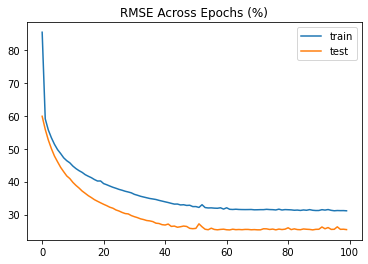

In [35]:
# --- Evaluate Model ---

# get rmse (%)
train_rmse = (model_fit.history['root_mean_squared_error'] / y_train.mean()) * 100
test_rmse = (model_fit.history['val_root_mean_squared_error'] / y_test.mean()) * 100

# plot rmse across epochs
plt.plot(train_rmse, label='train')
plt.plot(test_rmse, label='test')
plt.legend()
plt.title('RMSE Across Epochs (%)')

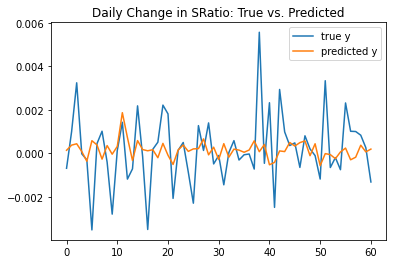

In [36]:
# --- Model Prediction ---

# generate network output for input data
y_pred = model.predict(X_test)

# inverse the scaled data
y_pred_inv = scalery.inverse_transform(y_pred)
y_test_inv = scalery.inverse_transform(y_test)

# plot
plt.plot(y_test_inv, label='true y')
plt.plot(y_pred_inv, label='predicted y')
plt.legend()
plt.title('Daily Change in SRatio: True vs. Predicted');

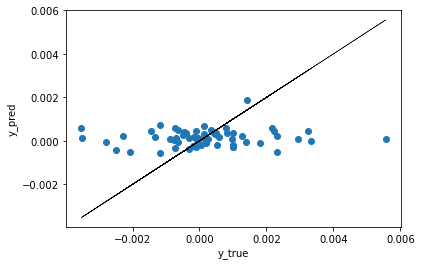

In [46]:
plt.scatter(y_test_inv, y_pred_inv)
plt.plot(y_test_inv, y_test_inv, color='black', lw=.5)
plt.xlabel('y_true')
plt.ylabel('y_pred');

# Tune Parameters via Grid Search: Attempt 1

#### Parameters: epoch, batch_size, # of neurons in the hidden layer

In [37]:
# --- Function to Create Model ---
def create_model(neurons=8):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=8, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer='Adamax', metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: epoch and batch size ---

# create model
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
neurons = [8, 10, 12, 14, 16, 18, 20, 22]
param_grid = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.093176 using {'batch_size': 10, 'epochs': 100, 'neurons': 18}
-0.170529 (0.030167) with: {'batch_size': 10, 'epochs': 10, 'neurons': 8}
-0.204725 (0.090251) with: {'batch_size': 10, 'epochs': 10, 'neurons': 10}
-0.148926 (0.022116) with: {'batch_size': 10, 'epochs': 10, 'neurons': 12}
-0.140632 (0.024051) with: {'batch_size': 10, 'epochs': 10, 'neurons': 14}
-0.136760 (0.031191) with: {'batch_size': 10, 'epochs': 10, 'neurons': 16}
-0.127928 (0.023280) with: {'batch_size': 10, 'epochs': 10, 'neurons': 18}
-0.164038 (0.035176) with: {'batch_size': 10, 'epochs': 10, 'neurons': 20}
-0.124302 (0.030797) with: {'batch_size': 10, 'epochs': 10, 'neurons': 22}
-0.113227 (0.021084) with: {'batch_size': 10, 'epochs': 50, 'neurons': 8}
-0.112152 (0.009321) with: {'batch_size': 10, 'epochs': 50, 'neurons': 10}
-0.101181 (0.011762) with: {'batch_size': 10, 'epochs': 50, 'neurons': 12}
-0.113747 (0.023042) with: {'batch_size': 10, 'epochs': 50, 'neurons': 14}
-0.102270 (0.017819) with: {'ba

Best: -0.093271 using {'batch_size': 10, 'epochs': 100, 'neurons': 14}
-0.145536 (0.017463) with: {'batch_size': 10, 'epochs': 10, 'neurons': 8}
-0.180940 (0.058168) with: {'batch_size': 10, 'epochs': 10, 'neurons': 10}
-0.150069 (0.039314) with: {'batch_size': 10, 'epochs': 10, 'neurons': 12}
-0.161363 (0.029768) with: {'batch_size': 10, 'epochs': 10, 'neurons': 14}
-0.132898 (0.032821) with: {'batch_size': 10, 'epochs': 10, 'neurons': 16}
-0.130584 (0.021355) with: {'batch_size': 10, 'epochs': 10, 'neurons': 18}
-0.119232 (0.022934) with: {'batch_size': 10, 'epochs': 10, 'neurons': 20}
-0.122064 (0.015560) with: {'batch_size': 10, 'epochs': 10, 'neurons': 22}
-0.117153 (0.013595) with: {'batch_size': 10, 'epochs': 50, 'neurons': 8}
-0.097255 (0.013474) with: {'batch_size': 10, 'epochs': 50, 'neurons': 10}
-0.100436 (0.018903) with: {'batch_size': 10, 'epochs': 50, 'neurons': 12}
-0.105621 (0.018369) with: {'batch_size': 10, 'epochs': 50, 'neurons': 14}
-0.097519 (0.018890) with: {'ba

Best: -0.093550 using {'batch_size': 10, 'epochs': 100, 'neurons': 14}
-0.149885 (0.023676) with: {'batch_size': 10, 'epochs': 10, 'neurons': 8}
-0.137026 (0.028711) with: {'batch_size': 10, 'epochs': 10, 'neurons': 10}
-0.136166 (0.022977) with: {'batch_size': 10, 'epochs': 10, 'neurons': 12}
-0.156501 (0.031748) with: {'batch_size': 10, 'epochs': 10, 'neurons': 14}
-0.142774 (0.033690) with: {'batch_size': 10, 'epochs': 10, 'neurons': 16}
-0.131168 (0.023236) with: {'batch_size': 10, 'epochs': 10, 'neurons': 18}
-0.146837 (0.027285) with: {'batch_size': 10, 'epochs': 10, 'neurons': 20}
-0.139483 (0.044471) with: {'batch_size': 10, 'epochs': 10, 'neurons': 22}
-0.107157 (0.008882) with: {'batch_size': 10, 'epochs': 50, 'neurons': 8}
-0.104156 (0.014217) with: {'batch_size': 10, 'epochs': 50, 'neurons': 10}
-0.109657 (0.018287) with: {'batch_size': 10, 'epochs': 50, 'neurons': 12}
-0.102775 (0.015028) with: {'batch_size': 10, 'epochs': 50, 'neurons': 14}
-0.097470 (0.014696) with: {'ba

Best: -0.093642 using {'batch_size': 10, 'epochs': 100, 'neurons': 22}
-0.195821 (0.056458) with: {'batch_size': 10, 'epochs': 10, 'neurons': 8}
-0.161873 (0.034628) with: {'batch_size': 10, 'epochs': 10, 'neurons': 10}
-0.163730 (0.025926) with: {'batch_size': 10, 'epochs': 10, 'neurons': 12}
-0.170146 (0.057813) with: {'batch_size': 10, 'epochs': 10, 'neurons': 14}
-0.145966 (0.040318) with: {'batch_size': 10, 'epochs': 10, 'neurons': 16}
-0.135313 (0.043316) with: {'batch_size': 10, 'epochs': 10, 'neurons': 18}
-0.126394 (0.023230) with: {'batch_size': 10, 'epochs': 10, 'neurons': 20}
-0.121395 (0.015340) with: {'batch_size': 10, 'epochs': 10, 'neurons': 22}
-0.104846 (0.014938) with: {'batch_size': 10, 'epochs': 50, 'neurons': 8}
-0.113579 (0.008458) with: {'batch_size': 10, 'epochs': 50, 'neurons': 10}
-0.103940 (0.016772) with: {'batch_size': 10, 'epochs': 50, 'neurons': 12}
-0.098484 (0.017725) with: {'batch_size': 10, 'epochs': 50, 'neurons': 14}
-0.105551 (0.016920) with: {'ba

Best: -0.092461 using {'batch_size': 20, 'epochs': 100, 'neurons': 20}
-0.151247 (0.030138) with: {'batch_size': 10, 'epochs': 10, 'neurons': 8}
-0.146646 (0.027104) with: {'batch_size': 10, 'epochs': 10, 'neurons': 10}
-0.138794 (0.022648) with: {'batch_size': 10, 'epochs': 10, 'neurons': 12}
-0.128379 (0.007411) with: {'batch_size': 10, 'epochs': 10, 'neurons': 14}
-0.125483 (0.015955) with: {'batch_size': 10, 'epochs': 10, 'neurons': 16}
-0.147737 (0.011472) with: {'batch_size': 10, 'epochs': 10, 'neurons': 18}
-0.143482 (0.029570) with: {'batch_size': 10, 'epochs': 10, 'neurons': 20}
-0.127807 (0.034194) with: {'batch_size': 10, 'epochs': 10, 'neurons': 22}
-0.116417 (0.013840) with: {'batch_size': 10, 'epochs': 50, 'neurons': 8}
-0.097739 (0.017888) with: {'batch_size': 10, 'epochs': 50, 'neurons': 10}
-0.116748 (0.017596) with: {'batch_size': 10, 'epochs': 50, 'neurons': 12}
-0.098886 (0.015104) with: {'batch_size': 10, 'epochs': 50, 'neurons': 14}
-0.102550 (0.011732) with: {'ba

#### Optimal values:
- epochs = 100
- batch_size = 10
- neurons = 14

#### Parameter: activation function, optimizer
Fixed:
- epochs = 100
- batch_size = 10 
- neurons = 14

In [38]:
# --- Function to Create Model ---
def create_model(activation='tanh', optimizer='Adamax'):
    # create model
    model = Sequential()
    model.add(Dense(14, input_dim=8, activation=activation))
    model.add(Dense(1, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer=optimizer, metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# define the grid search parameters
activation = ['tanh', 'sigmoid', 'elu', 'selu', 'exponential', 'linear']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(activation=activation, optimizer=optimizer)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.092558 using {'activation': 'elu', 'optimizer': 'Adam'}
-0.096275 (0.017377) with: {'activation': 'tanh', 'optimizer': 'SGD'}
-0.095445 (0.015466) with: {'activation': 'tanh', 'optimizer': 'RMSprop'}
-0.151242 (0.018369) with: {'activation': 'tanh', 'optimizer': 'Adagrad'}
-0.094386 (0.016708) with: {'activation': 'tanh', 'optimizer': 'Adam'}
-0.094257 (0.016338) with: {'activation': 'tanh', 'optimizer': 'Adamax'}
-0.093341 (0.016885) with: {'activation': 'tanh', 'optimizer': 'Nadam'}
-0.092760 (0.015031) with: {'activation': 'sigmoid', 'optimizer': 'SGD'}
-0.093068 (0.015827) with: {'activation': 'sigmoid', 'optimizer': 'RMSprop'}
-0.105211 (0.013289) with: {'activation': 'sigmoid', 'optimizer': 'Adagrad'}
-0.093567 (0.016894) with: {'activation': 'sigmoid', 'optimizer': 'Adam'}
-0.093817 (0.016601) with: {'activation': 'sigmoid', 'optimizer': 'Adamax'}
-0.094097 (0.017207) with: {'activation': 'sigmoid', 'optimizer': 'Nadam'}
-0.100407 (0.011698) with: {'activation': 'elu', 

Best: -0.091833 using {'activation': 'linear', 'optimizer': 'SGD'}
-0.095347 (0.016773) with: {'activation': 'tanh', 'optimizer': 'SGD'}
-0.094170 (0.015988) with: {'activation': 'tanh', 'optimizer': 'RMSprop'}
-0.187337 (0.089066) with: {'activation': 'tanh', 'optimizer': 'Adagrad'}
-0.095704 (0.014644) with: {'activation': 'tanh', 'optimizer': 'Adam'}
-0.097962 (0.015568) with: {'activation': 'tanh', 'optimizer': 'Adamax'}
-0.093265 (0.015865) with: {'activation': 'tanh', 'optimizer': 'Nadam'}
-0.101977 (0.012675) with: {'activation': 'sigmoid', 'optimizer': 'SGD'}
-0.094380 (0.017446) with: {'activation': 'sigmoid', 'optimizer': 'RMSprop'}
-0.106861 (0.018975) with: {'activation': 'sigmoid', 'optimizer': 'Adagrad'}
-0.093295 (0.015905) with: {'activation': 'sigmoid', 'optimizer': 'Adam'}
-0.093878 (0.014953) with: {'activation': 'sigmoid', 'optimizer': 'Adamax'}
-0.093922 (0.014553) with: {'activation': 'sigmoid', 'optimizer': 'Nadam'}
-0.099259 (0.017961) with: {'activation': 'elu'

#### Test again, with narrowed down options:

In [47]:
# --- Function to Create Model ---
def create_model(activation='tanh', optimizer='Adam'):
    # create model
    model = Sequential()
    model.add(Dense(14, input_dim=8, activation=activation))
    model.add(Dense(1, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer=optimizer, metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# define the grid search parameters
activation = ['tanh', 'sigmoid', 'elu', 'linear']
optimizer = ['SGD', 'Adam', 'Nadam']
param_grid = dict(activation=activation, optimizer=optimizer)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.093249 using {'activation': 'sigmoid', 'optimizer': 'Adam'}
-0.099331 (0.011773) with: {'activation': 'tanh', 'optimizer': 'SGD'}
-0.095767 (0.017686) with: {'activation': 'tanh', 'optimizer': 'Adam'}
-0.095898 (0.017399) with: {'activation': 'tanh', 'optimizer': 'Nadam'}
-0.101178 (0.018145) with: {'activation': 'sigmoid', 'optimizer': 'SGD'}
-0.093249 (0.016397) with: {'activation': 'sigmoid', 'optimizer': 'Adam'}
-0.094503 (0.016012) with: {'activation': 'sigmoid', 'optimizer': 'Nadam'}
-0.094820 (0.016134) with: {'activation': 'elu', 'optimizer': 'SGD'}
-0.095330 (0.017016) with: {'activation': 'elu', 'optimizer': 'Adam'}
-0.095077 (0.017853) with: {'activation': 'elu', 'optimizer': 'Nadam'}
-0.098451 (0.015312) with: {'activation': 'linear', 'optimizer': 'SGD'}
-0.094950 (0.017204) with: {'activation': 'linear', 'optimizer': 'Adam'}
-0.093566 (0.016913) with: {'activation': 'linear', 'optimizer': 'Nadam'}

Best: -0.093657 using {'activation': 'linear', 'optimizer': 'Nadam

#### Optimal value:
- activation = 'sigmoid'
- optimizer = 'adam'

#### Parameter: weight initialization
Fixed:
- epochs = 100
- batch_size = 10 
- neurons = 14
- activation = 'sigmoid'
- optimizer = 'adam'

In [48]:
# --- Function to Create Model ---
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(14, input_dim=8, kernel_initializer=init_mode, activation='sigmoid'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer='Adam', metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.091970 using {'init_mode': 'normal'}
-0.093132 (0.015418) with: {'init_mode': 'uniform'}
-0.093666 (0.016136) with: {'init_mode': 'lecun_uniform'}
-0.091970 (0.016046) with: {'init_mode': 'normal'}
-0.093612 (0.016128) with: {'init_mode': 'zero'}
-0.095697 (0.018414) with: {'init_mode': 'glorot_normal'}
-0.093123 (0.015997) with: {'init_mode': 'glorot_uniform'}
-0.093610 (0.015383) with: {'init_mode': 'he_normal'}
-0.093408 (0.016139) with: {'init_mode': 'he_uniform'}

Best: -0.092740 using {'init_mode': 'uniform'}
-0.092740 (0.016275) with: {'init_mode': 'uniform'}
-0.094536 (0.017711) with: {'init_mode': 'lecun_uniform'}
-0.093078 (0.015724) with: {'init_mode': 'normal'}
-0.094327 (0.016625) with: {'init_mode': 'zero'}
-0.097628 (0.019333) with: {'init_mode': 'glorot_normal'}
-0.094093 (0.018377) with: {'init_mode': 'glorot_uniform'}
-0.095437 (0.016740) with: {'init_mode': 'he_normal'}
-0.095322 (0.015523) with: {'init_mode': 'he_uniform'}

Best: -0.092553 using {'init_mode

#### Optimal value:
- kernel_initializer = 'uniform'

### Resulting Network:
- epochs = 100
- batch_size = 10 
- neurons = 14
- activation = 'sigmoid'
- optimizer = 'adam'
- kernel_initializer = 'uniform'

# Test Network:

In [49]:
# --- Train Model with Tuned Hyperparameters ---
model = create_model()
model_fit = model.fit(X_train, y_train, batch_size = 10, epochs = 100, validation_data = (X_test, y_test))

Epoch 1/100
35/35 [==============================] - 1s 9ms/step - loss: 0.0459 - root_mean_squared_error: 0.2131 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0740
Epoch 2/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0089 - root_mean_squared_error: 0.0940 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 3/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0733
Epoch 4/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0073 - root_mean_squared_error: 0.0848 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737
Epoch 5/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0118 - root_mean_squared_error: 0.1075 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 6/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0082 - root_mean_squared_error: 0.0901 - val_loss: 0.0054 - val_root_m

Epoch 49/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0084 - root_mean_squared_error: 0.0913 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0763
Epoch 50/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0102 - root_mean_squared_error: 0.1007 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0751
Epoch 51/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0084 - root_mean_squared_error: 0.0910 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737
Epoch 52/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 53/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0059 - root_mean_squared_error: 0.0755 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0749
Epoch 54/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0096 - root_mean_squared_error: 0.0975 - val_loss: 0.0054 - val_

Text(0.5, 1.0, 'RMSE Across Epochs (%)')

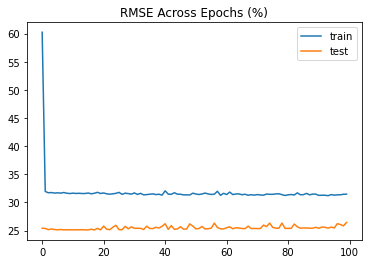

In [50]:
# --- Evaluate Model ---

# get rmse (%)
train_rmse = (model_fit.history['root_mean_squared_error'] / y_train.mean()) * 100
test_rmse = (model_fit.history['val_root_mean_squared_error'] / y_test.mean()) * 100

# plot rmse across epochs
plt.plot(train_rmse, label='train')
plt.plot(test_rmse, label='test')
plt.legend()
plt.title('RMSE Across Epochs (%)')

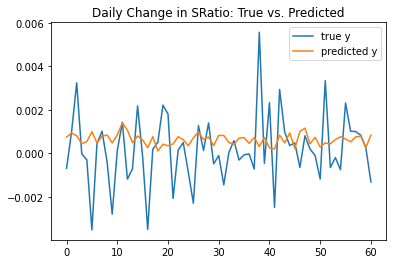

In [51]:
# --- Model Prediction ---

# generate network output for input data
y_pred = model.predict(X_test)

# inverse the scaled data
y_pred_inv = scalery.inverse_transform(y_pred)
y_test_inv = scalery.inverse_transform(y_test)

# plot
plt.plot(y_test_inv, label='true y')
plt.plot(y_pred_inv, label='predicted y')
plt.legend()
plt.title('Daily Change in SRatio: True vs. Predicted');

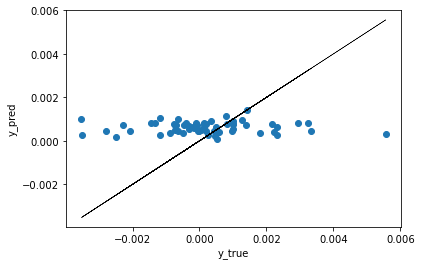

In [52]:
plt.scatter(y_test_inv, y_pred_inv)
plt.plot(y_test_inv, y_test_inv, color='black', lw=.5)
plt.xlabel('y_true')
plt.ylabel('y_pred');

# Tune Parameters via Grid Search: Attempt 2 (with LM optimizer)

#### Parameters: 
- epoch, batch_size, # of neurons in the hidden layer
- weight initialization

Fixed:
- optimizer = LM
- activation = 'tanh'

In [75]:
# --- Function to Create Model ---
def create_model(neurons=12):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=8, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    
    # wrap and compile model
    model_wrapper = lm.ModelWrapper(model)
    model_wrapper.compile(
        optimizer=SGD(learning_rate=0.1),
        loss=lm.MeanSquaredError(),
        metrics=[RootMeanSquaredError()])
    
    return model_wrapper

# --- Tuning Parameters: epoch and batch size ---

# create model
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
neurons = [12, 14, 16, 18, 20, 22]
param_grid = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.111717 using {'batch_size': 10, 'epochs': 10, 'neurons': 14}
-0.113048 (0.026338) with: {'batch_size': 10, 'epochs': 10, 'neurons': 12}
-0.111717 (0.016416) with: {'batch_size': 10, 'epochs': 10, 'neurons': 14}
-0.121773 (0.006216) with: {'batch_size': 10, 'epochs': 10, 'neurons': 16}
-0.117766 (0.013117) with: {'batch_size': 10, 'epochs': 10, 'neurons': 18}
-0.115387 (0.028060) with: {'batch_size': 10, 'epochs': 10, 'neurons': 20}
-0.122089 (0.036011) with: {'batch_size': 10, 'epochs': 10, 'neurons': 22}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 12}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 14}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 16}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 18}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 20}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 22}
nan (nan) with: {'batch_size': 10, 'epochs': 100, 'neurons': 12}
nan (nan) with: {'batch_size': 

Best: -0.106106 using {'batch_size': 10, 'epochs': 10, 'neurons': 20}
-0.114781 (0.028669) with: {'batch_size': 10, 'epochs': 10, 'neurons': 12}
-0.108671 (0.014314) with: {'batch_size': 10, 'epochs': 10, 'neurons': 14}
-0.134540 (0.015262) with: {'batch_size': 10, 'epochs': 10, 'neurons': 16}
-0.121319 (0.019313) with: {'batch_size': 10, 'epochs': 10, 'neurons': 18}
-0.106106 (0.017360) with: {'batch_size': 10, 'epochs': 10, 'neurons': 20}
-0.114934 (0.018134) with: {'batch_size': 10, 'epochs': 10, 'neurons': 22}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 12}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 14}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 16}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 18}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 20}
-0.133466 (0.039499) with: {'batch_size': 10, 'epochs': 50, 'neurons': 22}
nan (nan) with: {'batch_size': 10, 'epochs': 100, 'neurons': 12}
nan (nan) with: {'ba

Best: -0.108067 using {'batch_size': 10, 'epochs': 10, 'neurons': 16}
-0.121887 (0.040377) with: {'batch_size': 10, 'epochs': 10, 'neurons': 12}
-0.111793 (0.015604) with: {'batch_size': 10, 'epochs': 10, 'neurons': 14}
-0.108067 (0.013826) with: {'batch_size': 10, 'epochs': 10, 'neurons': 16}
-0.122731 (0.015747) with: {'batch_size': 10, 'epochs': 10, 'neurons': 18}
-0.108442 (0.014464) with: {'batch_size': 10, 'epochs': 10, 'neurons': 20}
-0.121776 (0.024188) with: {'batch_size': 10, 'epochs': 10, 'neurons': 22}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 12}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 14}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 16}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 18}
nan (nan) with: {'batch_size': 10, 'epochs': 50, 'neurons': 20}
-0.262914 (0.145190) with: {'batch_size': 10, 'epochs': 50, 'neurons': 22}
nan (nan) with: {'batch_size': 10, 'epochs': 100, 'neurons': 12}
nan (nan) with: {'ba

#### Parameters: 
- number of neurons in the hidden layer
- weight initialization

Fixed:
- optimizer = LM
- activation = 'tanh'
- epoch = 10
- batch_size = 10

In [76]:
# --- Function to Create Model ---
def create_model(neurons=12):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=8, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    
    # wrap and compile model
    model_wrapper = lm.ModelWrapper(model)
    model_wrapper.compile(
        optimizer=SGD(learning_rate=0.1),
        loss=lm.MeanSquaredError(),
        metrics=[RootMeanSquaredError()])
    
    return model_wrapper

# --- Tuning Parameters: epoch and batch size ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=10, verbose=0)

# define the grid search parameters
neurons = [12, 14, 16, 18, 20, 22]
param_grid = dict(neurons=neurons)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.103364 using {'neurons': 14}
-0.109446 (0.024200) with: {'neurons': 12}
-0.103364 (0.016440) with: {'neurons': 14}
-0.107065 (0.014808) with: {'neurons': 16}
-0.116302 (0.017523) with: {'neurons': 18}
-0.115552 (0.021016) with: {'neurons': 20}
-0.113740 (0.023961) with: {'neurons': 22}

Best: -0.099052 using {'neurons': 14}
-0.109107 (0.011283) with: {'neurons': 12}
-0.099052 (0.015527) with: {'neurons': 14}
-0.123255 (0.024169) with: {'neurons': 16}
-0.112213 (0.018943) with: {'neurons': 18}
-0.107439 (0.018866) with: {'neurons': 20}
-0.110668 (0.019904) with: {'neurons': 22}

Best: -0.107429 using {'neurons': 12}
-0.107429 (0.013610) with: {'neurons': 12}
-0.124752 (0.026871) with: {'neurons': 14}
-0.111033 (0.012974) with: {'neurons': 16}
-0.111411 (0.014787) with: {'neurons': 18}
-0.114375 (0.008646) with: {'neurons': 20}
-0.112991 (0.013780) with: {'neurons': 22}

Best: -0.108990 using {'neurons': 14}
-0.140648 (0.054668) with: {'neurons': 12}
-0.108990 (0.018832) with: {

#### Parameters: 
- weight initialization

Fixed:
- optimizer = LM
- activation = 'tanh'
- epoch = 10
- batch_size = 10
- number of neurons in the hidden layer = 14

In [77]:
# --- Function to Create Model ---
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(14, input_dim=8, kernel_initializer=init_mode, activation='tanh'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='linear'))
    
    # wrap and compile model
    model_wrapper = lm.ModelWrapper(model)
    model_wrapper.compile(
        optimizer=SGD(learning_rate=0.1),
        loss=lm.MeanSquaredError(),
        metrics=[RootMeanSquaredError()])
    
    return model_wrapper

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=10, verbose=0)

# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.103876 using {'init_mode': 'glorot_uniform'}
-0.128562 (0.039473) with: {'init_mode': 'uniform'}
-0.114127 (0.022332) with: {'init_mode': 'lecun_uniform'}
-0.126050 (0.016571) with: {'init_mode': 'normal'}
-0.119037 (0.016800) with: {'init_mode': 'glorot_normal'}
-0.103876 (0.015121) with: {'init_mode': 'glorot_uniform'}
-0.110318 (0.019670) with: {'init_mode': 'he_normal'}
-0.106956 (0.012422) with: {'init_mode': 'he_uniform'}

Best: -0.099115 using {'init_mode': 'he_uniform'}
-0.107755 (0.014078) with: {'init_mode': 'uniform'}
-0.110081 (0.018970) with: {'init_mode': 'lecun_uniform'}
-0.118737 (0.028752) with: {'init_mode': 'normal'}
-0.099786 (0.017257) with: {'init_mode': 'glorot_normal'}
-0.109710 (0.010745) with: {'init_mode': 'glorot_uniform'}
-0.111775 (0.011601) with: {'init_mode': 'he_normal'}
-0.099115 (0.016294) with: {'init_mode': 'he_uniform'}

Best: -0.103972 using {'init_mode': 'glorot_uniform'}
-0.119861 (0.025784) with: {'init_mode': 'uniform'}
-0.112838 (0.0

### Resulting Network:
- epochs = 10
- batch_size = 10 
- neurons = 14
- activation = 'tanh'
- optimizer = LM
- kernel_initializer = 'glorot_uniform'

# Test Network:

In [78]:
# --- Create Model ---
model = create_model(init_mode='glorot_uniform')

# --- Compile and Train Model ---
model_wrapper = lm.ModelWrapper(model)

model_wrapper.compile(
    optimizer=SGD(learning_rate=0.1),
    loss=lm.MeanSquaredError(),
    metrics=[RootMeanSquaredError()])

model_wrapper.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/10
35/35 [==============================] - 1s 23ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0301 - root_mean_squared_error: 0.2336 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 2/10
35/35 [==============================] - 0s 13ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0000e+00 - root_mean_squared_error: 0.0986 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838ss: 0.0000e+00 - root_mean_squared_error: 0.095 - ETA: 0s - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0000e+00 - root_mean_squared_error: 0.0
Epoch 3/10
35/35 [==============================] - 0s 11ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0000e+00 - root_mean_squared_error: 0.0959 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 4/10
35/35 [==============================] - 0s 12ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0000e+00 - root_mean_squared_error: 0.1013 - val_loss: 0.

Text(0.5, 1.0, 'RMSE Across Epochs (%)')

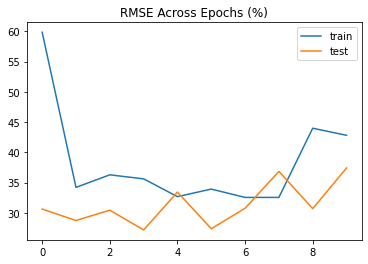

In [79]:
# --- Evaluate Model ---

# get rmse (%)
train_rmse = (model_wrapper.history.history['root_mean_squared_error'] / y_train.mean()) * 100
test_rmse = (model_wrapper.history.history['val_root_mean_squared_error'] / y_test.mean()) * 100

# plot rmse across epochs
plt.plot(train_rmse, label='train')
plt.plot(test_rmse, label='test')
plt.legend()
plt.title('RMSE Across Epochs (%)')

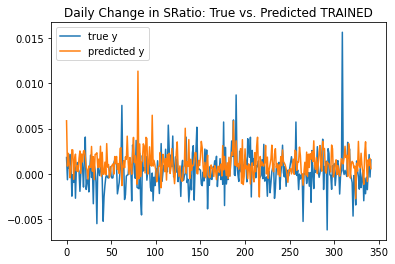

In [83]:
# --- Model Prediction: TRAINED ---

# generate network output for input data
y_pred = model.predict(X_train)

# inverse the scaled data
y_pred_inv = scalery.inverse_transform(y_pred)
y_train_inv = scalery.inverse_transform(y_train)

# plot
plt.plot(y_train_inv, label='true y')
plt.plot(y_pred_inv, label='predicted y')
plt.legend()
plt.title('Daily Change in SRatio: True vs. Predicted TRAINED');

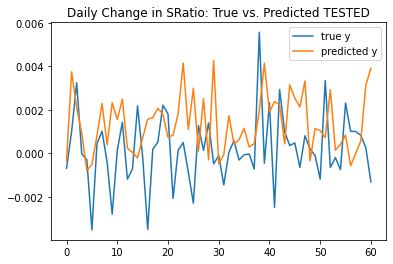

In [84]:
# --- Model Prediction: TESTED ---

# generate network output for input data
y_pred = model.predict(X_test)

# inverse the scaled data
y_pred_inv = scalery.inverse_transform(y_pred)
y_test_inv = scalery.inverse_transform(y_test)

# plot
plt.plot(y_test_inv, label='true y')
plt.plot(y_pred_inv, label='predicted y')
plt.legend()
plt.title('Daily Change in SRatio: True vs. Predicted TESTED');

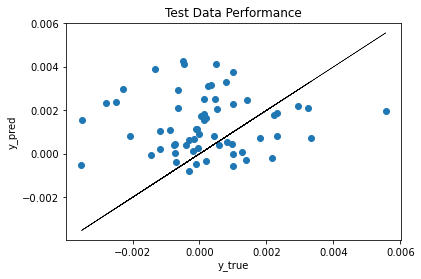

In [85]:
plt.scatter(y_test_inv, y_pred_inv)
plt.plot(y_test_inv, y_test_inv, color='black', lw=.5)
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Test Data Performance');